In [1]:
import os.path, sys
import Bio   

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance

from joblib import Parallel, delayed
from pathlib import Path
import timeit

import matplotlib.pyplot as plt

print('Done with initial import')


create_new = False
printing = True
removing_cols = True
remove_diagonals = False

pdb_path = "/pdb/pdb/"
data_path = Path('/data/cresswellclayec/Pfam-A.full')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir


out_dir = '%s/protein_data/di/' % biowulf_dir
out_metric_dir = '%s/protein_data/metrics/' % biowulf_dir

processed_data_dir = "%s/protein_data/data_processing_output/" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir

pdb_id = "1r1o"
pdb_id = "1zdr"
pdb_id = "3bcc"

prody_df = pd.read_csv('%s/%s_pdb_df.csv' % (pdb_dir, pdb_id))
pdb_file = "%spdb%s.ent" % (pdb_dir,pdb_id)


pdb2msa_row = prody_df.iloc[0]
pfam_id = pdb2msa_row['Pfam']
pdb_chain = pdb2msa_row['Chain']
print(pdb2msa_row)


from data_processing import data_processing_pdb2msa
import single_protein_plot_pydca as spp

Done with initial import
Unnamed: 0                                                           0
Unnamed: 0.1                                                         0
PDB ID                                                            3bcc
Chain                                                                D
Polypeptide Index                                                    0
Pfam                                                           PF02167
accession                                                   PF02167.18
class                                                           Domain
id                                                        Cytochrom_C1
type                                                            Pfam-A
PDB Sequence         SDLELHPPSYPWSHRGPLSSLDHTSIRRGFQVYKQVCSSCHSMDYV...
ali_end                                                            228
ali_start                                                           12
bitscore                                            

In [2]:
#pdb_id = sys.argv[1]
#pfam_id = sys.argv[2]
pdb_id = '1zdr'
pdb_id = '2a78'




prody_df = pd.read_csv('%s/%s_pdb_df.csv' % (pdb_dir, pdb_id))
pdb2msa_row  = prody_df.iloc[0]
print('\n\nGetting msa with following pdb2msa entry:\n', pdb2msa_row)
#try:
print(pdb2msa_row)
pfam_id = pdb2msa_row['Pfam']
pdb_id = pdb2msa_row['PDB ID']
pdb_chain = pdb2msa_row['Chain']

ref_outfile = Path(processed_data_dir, '%s_ref.fa' % pfam_id)

pfam_dimensions_file = "%s/%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
pfam_dimensions = np.load(pfam_dimensions_file)
if len(pfam_dimensions)==7:
    [n_col, n_seq, m_eff, ct_ER, ct_MF, ct_PMF, ct_PLM] = pfam_dimensions
elif len(pfam_dimensions)==6: # new pfam_dimensions created in run_method_comparison. we dont need MF..
    [n_col, n_seq, m_eff, ct_ER, ct_PMF, ct_PLM] = pfam_dimensions
elif len(pfam_dimensions)==3:
    [n_col, n_seq, m_eff] = pfam_dimensions




Getting msa with following pdb2msa entry:
 Unnamed: 0                                                           0
Unnamed: 0.1                                                         0
PDB ID                                                            2a78
Chain                                                                A
Polypeptide Index                                                    0
Pfam                                                           PF00071
accession                                                   PF00071.25
class                                                           Domain
id                                                                 Ras
type                                                            Pfam-A
PDB Sequence         ALHKVIMVGSGGVGKSALTLQFMYDEFVEDYEPTKADSYRKKVVLD...
ali_end                                                            164
ali_start                                                            4
bitscore                        

In [3]:

if removing_cols:
    s0 = np.load("%s/%s_%s_preproc_msa.npy" % (processed_data_dir, pfam_id, pdb_id))
    s_index = np.load("%s/%s_%s_preproc_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))
    #pdb_s_index = np.load("%s/%s_%s_preproc_pdb_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))
    removed_cols = np.load("%s/%s_%s_removed_cols.npy" % (processed_data_dir, pfam_id, pdb_id))
    ref_seq = np.load("%s/%s_%s_preproc_refseq.npy" % (processed_data_dir, pfam_id, pdb_id))
else:
    s0 = np.load("%s/%s_%s_allCols_msa.npy" % (processed_data_dir, pfam_id, pdb_id))
    s_index = np.load("%s/%s_%s_allCols_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))
    #pdb_s_index = np.load("%s/%s_%s_allCols_pdb_sindex.npy" % (processed_data_dir, pfam_id, pdb_id)) 
    removed_cols = np.load("%s/%s_%s_removed_cols.npy" % (processed_data_dir, pfam_id, pdb_id))
    ref_seq = np.load("%s/%s_%s_allCols_refseq.npy" % (processed_data_dir, pfam_id, pdb_id))
pdb_s_index = s_index # will need to rerun simulations with corrected data_processing (corrected on 3/15/22) to get pdb_s_index. not actually needed in contact mapping......

pfam_dimensions_file = "%s%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
pfam_dimensions = np.load(pfam_dimensions_file)
print(pdb_id)
print(pfam_dimensions)

[n_col, n_seq, m_eff, ct_ER, ct_PMF, ct_PLM] = pfam_dimensions
print('Number of Columns: ', n_col)
print('Number of sequences: ', n_seq)
print('Number of effective sequences: ', m_eff)
print('ER, PMF, PLM optimal distance: ', ct_ER, ct_PMF, ct_PLM)

ct_file = "%s%s_%s_ct.npy" % (pdb_dir, pdb_id, pfam_id)
ct = np.load(ct_file)


# load DI data
ER_di = np.load("%s/%s_%s_ER_di.npy" % (out_dir, pdb_id, pfam_id))
PMF_di_data = np.load("%s/%s_%s_PMF_di.npy" % (out_dir, pdb_id, pfam_id),allow_pickle=True)
PLM_di_data = np.load("%s/%s_%s_PLM_di.npy" % (out_dir, pdb_id, pfam_id),allow_pickle=True)


# transform pydca DI dictionary to DI matrices.
PLM_di = np.zeros(ER_di.shape)
PLM_di_dict = {}
for score_set in PLM_di_data:
    PLM_di_dict[(score_set[0][0], score_set[0][1])] = score_set[1]
for i, index_i in enumerate(s_index):
    for j, index_j in enumerate(s_index):
        if i==j:
            PLM_di[i,j] = 1.
            continue
        try:
            PLM_di[i,j] = PLM_di_dict[(index_i, index_j)]
            PLM_di[j,i] = PLM_di_dict[(index_i, index_j)] # symetric
        except(KeyError):
            continue

PMF_di = np.zeros(ER_di.shape)
PMF_di_dict = {}
for score_set in PMF_di_data:
    PMF_di_dict[(score_set[0][0], score_set[0][1])] = score_set[1]
for i, index_i in enumerate(s_index):
    for j, index_j in enumerate(s_index):
        if i==j:
            PMF_di[i,j] = 1.
            continue
        try:
            PMF_di[i,j] = PMF_di_dict[(index_i, index_j)]
            PMF_di[j,i] = PMF_di_dict[(index_i, index_j)] # symetric
        except(KeyError):
            continue


2a78
[1.43000000e+02 3.44810000e+04 9.16770560e+03 4.35294118e+00
 4.35294118e+00 4.35294118e+00]
Number of Columns:  143.0
Number of sequences:  34481.0
Number of effective sequences:  9167.705600644214
ER, PMF, PLM optimal distance:  4.352941176470588 4.352941176470588 4.352941176470588


# ER

In [4]:
file_end = "_ld5.npy"
file_end = ".npy"
fp_file = "%s%s_%s_ER_fp%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
tp_file = "%s%s_%s_ER_tp%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
er_fp = np.load(fp_file)
er_tp = np.load(tp_file)

pairs_matrix = np.empty((len(s_index),len(s_index)), dtype=object)                                                                                                   

for i, ii in enumerate(s_index):  
    for j, jj in enumerate(s_index):
        pairs_matrix[i,j] =(i,j)
print(pairs_matrix)
print(pairs_matrix.shape)

# Set contact distance
ct_dist = 8.
ct1 = ct.copy()
ct_pos = ct < ct_dist


ct1[ct_pos] = 1
ct1[~ct_pos] = 0



mask = np.triu(np.ones(ER_di.shape[0], dtype=bool), k=1)
# argsort sorts from low to high. [::-1] reverses 
order = ER_di[mask].argsort()[::-1]

ld_thresh = 0.
linear_distance = np.zeros((len(s_index),len(s_index)))                                                                                                   
for i, ii in enumerate(s_index):                                                                                                                          
    for j, jj in enumerate(s_index):                                                                                                                      
        linear_distance[i,j] = abs(ii - jj)   


ld = linear_distance >= ld_thresh                                                                                                                         
ld_flat = ld[mask][order]          

ER_di_flat = ER_di[mask][order][ld_flat]
ct_flat = ct1[mask][order][ld_flat]
dist_flat = ct[mask][order][ld_flat]
pairs_flat = pairs_matrix[mask][order][ld_flat]

plm_mask = np.triu(np.ones(PLM_di.shape[0], dtype=bool), k=1)
# argsort sorts from low to high. [::-1] reverses 
plm_order = PLM_di[mask].argsort()[::-1]

PLM_di_flat = PLM_di[plm_mask][plm_order][ld_flat]
PLM_ct_flat = ct1[plm_mask][plm_order][ld_flat]
PLM_dist_flat = ct[plm_mask][plm_order][ld_flat]
PLM_pairs_flat = pairs_matrix[plm_mask][plm_order][ld_flat]

mf_mask = np.triu(np.ones(PMF_di.shape[0], dtype=bool), k=1)
# argsort sorts from low to high. [::-1] reverses 
mf_order = PMF_di[mask].argsort()[::-1]

MF_di_flat = PMF_di[mf_mask][mf_order][ld_flat]
MF_ct_flat = ct1[mf_mask][mf_order][ld_flat]
MF_dist_flat = ct[mf_mask][mf_order][ld_flat]
MF_pairs_flat = pairs_matrix[mf_mask][mf_order][ld_flat]

[[(0, 0) (0, 1) (0, 2) ... (0, 140) (0, 141) (0, 142)]
 [(1, 0) (1, 1) (1, 2) ... (1, 140) (1, 141) (1, 142)]
 [(2, 0) (2, 1) (2, 2) ... (2, 140) (2, 141) (2, 142)]
 ...
 [(140, 0) (140, 1) (140, 2) ... (140, 140) (140, 141) (140, 142)]
 [(141, 0) (141, 1) (141, 2) ... (141, 140) (141, 141) (141, 142)]
 [(142, 0) (142, 1) (142, 2) ... (142, 140) (142, 141) (142, 142)]]
(143, 143)


In [5]:
# Find optimal contact distance for each method
from ecc_tools import roc_curve_new
ct_thres = np.linspace(6.,10.,18,endpoint=True)
ct_mat = ct.copy()

# ------------------------------------------- ER ----------------------------------------------------- #
auc_vals = np.zeros(len(ct_thres))
for i, ct_dist in enumerate(ct_thres):
    fpr, tpr, thresholds, auc, ct_pos_flat = roc_curve_new(ct_mat, ER_di, ct_thres[i], s_index, ld_thresh=ld_thresh)

    auc_vals[i] = auc

ER_i0 = np.argmax(auc_vals)

ct_ER_optimal = ct_thres[ER_i0]
fpr_ER_optimal, tpr_ER_optimal, thresholds, auc, ct_pos_flat_ER_optimal = roc_curve_new(ct_mat, ER_di, ct_thres[ER_i0], s_index, ld_thresh=ld_thresh)
auc_ER_optimal = auc 

ct1 = ct.copy()
ct_pos = ct1 < ct_ER_optimal
ct1[ct_pos] = 1                                                                                          
ct1[~ct_pos] = 0                                                                                                                                               
ct_flat_ER_optimal = ct1[mask][order]


# ------------------------------------------- PLM ---------------------------------------------------- #
auc_vals = np.zeros(len(ct_thres))
for i, ct_dist in enumerate(ct_thres):
    fpr, tpr, thresholds, auc, ct_pos_flat = roc_curve_new(ct_mat, PLM_di, ct_thres[i], s_index, ld_thresh=ld_thresh)
    auc_vals[i] = auc

PLM_i0 = np.argmax(auc_vals)

ct_PLM_optimal = ct_thres[PLM_i0]
fpr_PLM_optimal, tpr_PLM_optimal, thresholds, auc, ct_pos_flat_PLM_optimal = roc_curve_new(ct_mat, PLM_di, ct_thres[PLM_i0], s_index, ld_thresh=ld_thresh)
auc_PLM_optimal = auc 

ct1 = ct.copy()
ct_pos = ct1 < ct_PLM_optimal
ct1[ct_pos] = 1                                                                                          
ct1[~ct_pos] = 0                                                                                                                                               
ct_flat_PLM_optimal = ct1[plm_mask][plm_order]

# ------------------------------------------- MF ----------------------------------------------------- #
auc_vals = np.zeros(len(ct_thres))
for i, ct_dist in enumerate(ct_thres):
    fpr, tpr, thresholds, auc, ct_pos_flat = roc_curve_new(ct_mat, PMF_di, ct_thres[i], s_index, ld_thresh=ld_thresh)
    auc_vals[i] = auc

MF_i0 = np.argmax(auc_vals)

ct_MF_optimal = ct_thres[MF_i0]
fpr_MF_optimal, tpr_MF_optimal, thresholds, auc, ct_pos_flat_MF_optimal = roc_curve_new(ct_mat, PMF_di, ct_thres[MF_i0], s_index, ld_thresh=ld_thresh)
auc_MF_optimal = auc 

ct1 = ct.copy()
ct_pos = ct1 < ct_MF_optimal
ct1[ct_pos] = 1                                                                                          
ct1[~ct_pos] = 0                                                                                                                                               
ct_flat_MF_optimal = ct1[mf_mask][mf_order]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
ct_flat:  [1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
ld_flat:  [ True  True  True  True  True  True  True  True  True  True]
ct_flat (after ld constraint):  [1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
ct thresh 6.000000 gives auc = 0.934469
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
ct_flat:  [1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
ld_flat:  [ True  True  True  True  True  True  True  True  True  True]
ct_flat (after ld constraint):  [1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
ct thresh 6.235294 gives auc = 0.925351
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
ct_flat:  [1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
ld_flat:  [ True  True  True  True  True  True  True  True  True  True]
ct_flat (after ld constraint):  [1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
ct thresh 6.470588 gives auc = 0.919523
[ True  True  True  True  True  True  True  True  True  True  True 

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
ct_flat:  [1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
ld_flat:  [ True  True  True  True  True  True  True  True  True  True]
ct_flat (after ld constraint):  [1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
ct thresh 8.823529 gives auc = 0.702000
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
ct_flat:  [1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
ld_flat:  [ True  True  True  True  True  True  True  True  True  True]
ct_flat (after ld constraint):  [1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
ct thresh 9.058824 gives auc = 0.695747
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
ct_flat:  [1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
ld_flat:  [ True  True  True  True  True  True  True  True  True  True]
ct_flat (after ld constraint):  [1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
ct thresh 9.294118 gives auc = 0.690679
[ True  True  True  True  True  True  True  True  True  True  True 

In [6]:
print('ER does best for contact distance of %f with auc of %f' % (ct_ER_optimal, auc_ER_optimal))
print('PLM does best for contact distance of %f with auc of %f' % (ct_PLM_optimal, auc_PLM_optimal))
print('MF does best for contact distance of %f with auc of %f' % (ct_MF_optimal, auc_MF_optimal))

ER does best for contact distance of 6.000000 with auc of 0.934469
PLM does best for contact distance of 7.882353 with auc of 0.742395
MF does best for contact distance of 6.000000 with auc of 0.895891


# PLM

In [7]:
fp_file = "%s%s_%s_PLM_fp%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
tp_file = "%s%s_%s_PLM_tp%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
plm_fp = np.load(fp_file)
plm_tp = np.load(tp_file)

# Plot DI method comparison (plot functions) 

In [8]:
def plot_di_vs_ct(ax, ct_flat, dist_flat, dis_flat, ld_flat, labels):
    colors = 'brg'
    for ii, di_flat in enumerate(dis_flat):
        fmethod = True
        for i, contact in enumerate(ct_flat):
            if fmethod:
                ax.scatter(dist_flat[i], di_flat[i], marker='.',  c=colors[ii], label=labels[ii])
                fmethod=False
            else:
                ax.scatter(dist_flat[i], di_flat[i], marker='.',  c=colors[ii])

    ax.set_xlabel('Distance ($\AA$)')
    ax.set_ylabel('DI')
    return ax

In [9]:
def plot_di_compare_methods(ax, ct_flat, di1_flat, di2_flat, ld_flat, labels):
    ec = 'b'
    f1 = True
    f2 = True
    f3 = True
    for j in range(len(ct_flat), -1, -1):
        i = j-1
        contact = ct_flat[i]
        if not ld_flat[i]:
            if f1:
                ax.scatter(di1_flat[i], di2_flat[i], marker='x',  c='k', alpha=.2, label='to close')
                f1 = False
            else:
                ax.scatter(di1_flat[i], di2_flat[i],  marker='x',  c='k', alpha=.2)
    
        elif contact==1.:
            if f2:
                ax.scatter(di1_flat[i], di2_flat[i], marker='o', facecolors='none', edgecolors='g', label='contact')
                f2=False
            else:
                ax.scatter(di1_flat[i], di2_flat[i],  marker='o', facecolors='none', edgecolors='g')
        else:
            if f3:
                ax.scatter(di1_flat[i], di2_flat[i], marker='_', c='r', label='no contact')
                f3 = False
            else:
                ax.scatter(di1_flat[i], di2_flat[i], marker='_', c='r')
    ax.set_xlabel('%s DI' % labels[0])
    ax.set_ylabel('%s DI' % labels[1])
    return ax


In [10]:
if 0:
    labels = ['ER', 'PLM']
    flat_dis =  [ER_di_flat, PLM_di_flat]

    plt.figure(figsize=(5,5))
    ax = plt.subplot2grid((1,1),(0,0))
    ax = plot_di_vs_ct(ax, ct_flat, dist_flat, flat_dis, ld_flat, labels)
    ax.legend()
    plt.show()

    labels = ['ER', 'MF']
    flat_dis =  [ER_di_flat, MF_di_flat]

    plt.figure(figsize=(5,5))
    ax = plt.subplot2grid((1,1),(0,0))
    ax = plot_di_vs_ct(ax, ct_flat, dist_flat, flat_dis, ld_flat, labels)
    ax.legend()
    plt.show()

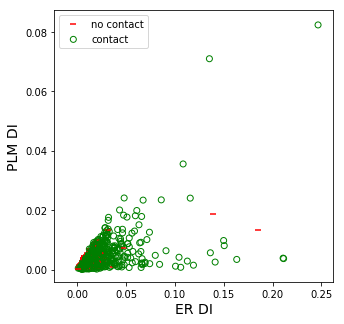

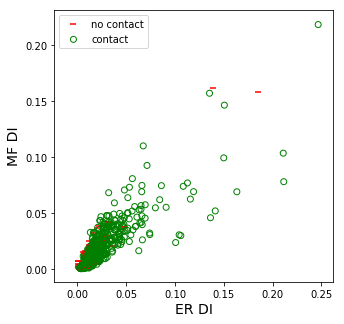

In [11]:
if 1:
    plt.figure(figsize=(5,5))
    ax = plt.subplot2grid((1,1),(0,0))
    ax = spp.plot_di_compare_methods(ax, ct, ER_di, PLM_di, ld_thresh, ct_dist, s_index, ['ER', 'PLM'])
    ax.legend()
    plt.show()

    plt.figure(figsize=(5,5))
    ax = plt.subplot2grid((1,1),(0,0))
    ax = spp.plot_di_compare_methods(ax, ct, ER_di, PMF_di, ld_thresh, ct_dist, s_index, ['ER', 'MF'])
    ax.legend()
    plt.show()

## PYDCA plotting Extracted

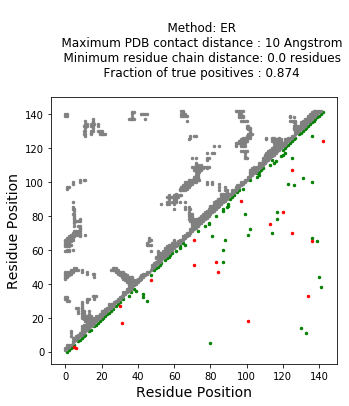

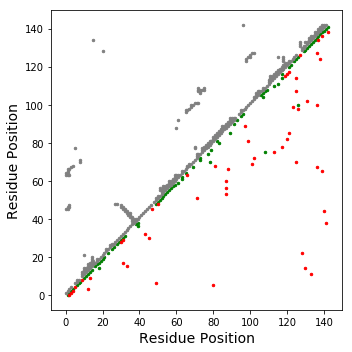

In [21]:
from single_protein_plot_pydca import plot_contact_map_ecc
plt.figure(figsize=(5,5.75))
ax = plt.subplot2grid((1,1),(0,0))
ax = plot_contact_map_ecc(ax, 'ER', pairs_flat, ct_flat, dist_flat, ER_di_flat, 10, s_index, ld_val=ld_thresh, title=True)
plt.tight_layout()

plt.figure(figsize=(5,5))
ax = plt.subplot2grid((1,1),(0,0))
ax = plot_contact_map_ecc(ax, 'ER', pairs_flat, ct_flat, dist_flat, ER_di_flat, ct_ER_optimal, s_index, ld_val=ld_thresh, title=False)
plt.tight_layout()

In [13]:
colors_hex = {"red": "#e41a1c", "blue": "#2258A5", "green": "#349C55", "purple": "#984ea3", "orange": "#FF8B00",
                      "yellow": "#ffff33", "grey": "#BBBBBB"}
colors_key = ["blue", "orange", "green"]
method2color = {"ER":"blue", "MF":"orange", "PLM":"green"}



In [14]:
from pydca.contact_visualizer import contact_visualizer
ref_outfile = Path(processed_data_dir, '%s_ref.fa' % pfam_id)
print(er_tp[:10])

ct_flats = [ct_flat, PLM_ct_flat, MF_ct_flat]
ct_flats_optimal = [ct_flat_ER_optimal, ct_flat_PLM_optimal, ct_flat_MF_optimal]

dis = [ER_di, PLM_di, PMF_di]

methods = ['ER', 'PLM', 'MF']

print('er_flat contacts, ', ct_flat)
print('plm_flat contacts', PLM_ct_flat)
tps = []
for ct_f in ct_flats:
    tp = np.cumsum(ct_f, dtype=float)
    print(len(tp))
#     if tp[-1] !=0:
#         tp /= tp[-1]
    tps.append(tp)
    
    
print('optimal er flat contacts, ', ct_flat_ER_optimal)
print('optimal plm flat contacts', ct_flat_PLM_optimal) 
tprs_optimal = [tpr_ER_optimal, tpr_PLM_optimal, tpr_MF_optimal]

optimal_ct_distances = [ct_ER_optimal, ct_PLM_optimal, ct_MF_optimal]

plmdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = str(ref_outfile),
    sorted_dca_scores = PLM_di_data,
    linear_dist = ld_thresh,
    contact_dist = ct_ER_optimal
)




[0.         0.00757576 0.00757576 0.04545455 0.04545455 0.0530303
 0.0530303  0.06818182 0.06818182 0.09090909]
er_flat contacts,  [1. 1. 1. ... 0. 0. 0.]
plm_flat contacts [1. 1. 1. ... 0. 0. 0.]
10153
10153
10153
optimal er flat contacts,  [1. 1. 1. ... 0. 0. 0.]
optimal plm flat contacts [1. 1. 1. ... 0. 0. 0.]


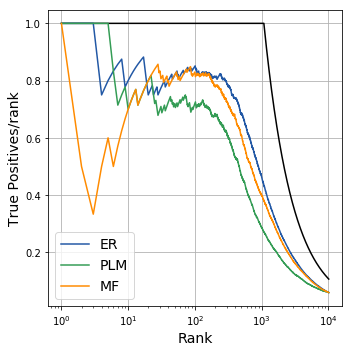

In [19]:
from single_protein_plot_pydca import plot_true_positive_rates_ecc
plt.figure(figsize=(5,5))
ax = plt.subplot2grid((1,1),(0,0))
ax = plot_true_positive_rates_ecc(ct.copy(), tps, methods, 10, ld_thresh, ax)
# ax = plot_true_positive_rates_ecc([plmdca_visualizer], dis, ct, methods, 5, 5, ax)

plt.tight_layout()

In [16]:
# This function should do the same thing as above but it calculates the flat contact 
# binary array using the contact distance and contact matrix.. ie no chance to have the wrong contact calculated
# above

def plot_true_positive_rates_ecc_new(method_visualizers, dis, ct, methods, contact_dist, linear_dist, ax):
    """Plotes the true positive rate per rank of DCA ranked site pairs.
    The x-axis is in log scale.

    Parameters
    ----------
        self : DCAVisualizer

    Returns
    -------
        true_positive_rates_dict : dict
            A dictionary whose keys are true positives types (pdb, or dca)
            and whose values are the corresponding true positive rates per
            rank.

    """
    mv = method_visualizers[0]
    true_positive_rates_dict = mv.compute_true_positive_rates()
    pdb_tpr = true_positive_rates_dict['pdb']
    max_rank = len(pdb_tpr)
    pdb_ranks = [i + 1 for i in range(max_rank)]
    ax.plot(pdb_ranks, pdb_tpr,color='k')
    
    # Set contact matrix with contact distance
    ct1 = ct.copy()
    ct_pos = ct < contact_dist
    ct1[ct_pos] = 1                                                                                          
    ct1[~ct_pos] = 0  
    
    for i, method_di in enumerate(dis):
        # Generate your TPR
        method_mask = np.triu(np.ones(method_di.shape[0], dtype=bool), k=1)
        method_order = method_di[method_mask].argsort()[::-1]
        method_ct_flat = ct1[method_mask][method_order]
        
        for ct_f in ct_flats:
            tp = np.cumsum(ct_f, dtype=float)
            print(len(tp))
        #     if tp[-1] !=0:
        #         tp /= tp[-1]
        
        print(method_ct_flat)
        max_rank = len(method_ct_flat)
        ranks = [j + 1 for j in range(max_rank)]
        tpr = [t/ranks[jj] for jj,t in enumerate(np.cumsum(method_ct_flat, dtype=float))]
        ax.plot(ranks, tpr, color=colors_hex[method2color[methods[i]]],label=methods[i])

        ax.set_xscale('log')
        ax_title = '''
        True Positive Rate Per Rank
        PDB cut-off distance : {} Angstrom
        Residue chain distance : {}
        '''
    ax.set_title(ax_title.format(
            contact_dist, linear_dist,
        )
    )
    ax.set_xlabel('Rank', fontsize=14)
    ax.set_ylabel('True Positives/Rank', fontsize=14)
    plt.legend(fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.show()
    return ax


	Chain distance between residues is Zero,
	returning top 12640 unfiltered DCA contacts

	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.

	PDB sequence has got gaps at the middle when aligned with reference.
	Usually residues are missing at the beginning and end of the chain.


10153
10153
10153
[0. 1. 1. ... 0. 0. 0.]
10153
10153
10153
[0. 0. 0. ... 0. 0. 0.]
10153
10153
10153
[0. 0. 0. ... 0. 0. 0.]


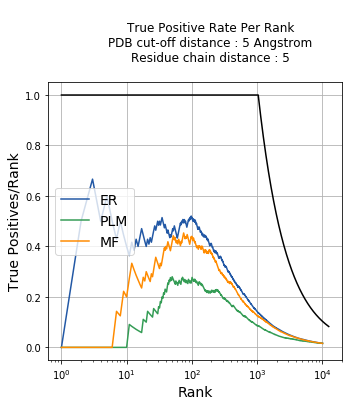

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figsize=(5,5.75))
ax = plt.subplot2grid((1,1),(0,0))
# ax = plot_true_positive_rates_ecc_new([plmdca_visualizer], , methods, 10, 5, ax)
ax = plot_true_positive_rates_ecc_new([plmdca_visualizer], dis, ct, methods, 5, 5, ax)

plt.tight_layout()


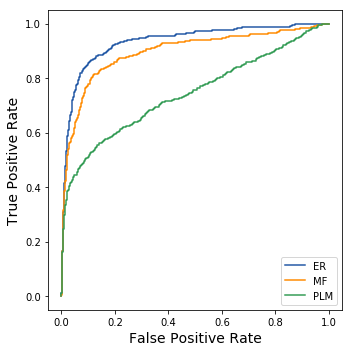

In [18]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot2grid((1,1),(0,0))
ax.plot(fpr_ER_optimal, tpr_ER_optimal, label='ER', color=colors_hex[method2color['ER']])
ax.plot(fpr_MF_optimal, tpr_MF_optimal, label='MF', color=colors_hex[method2color['MF']])
ax.plot(fpr_PLM_optimal, tpr_PLM_optimal, label='PLM', color=colors_hex[method2color['PLM']])
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.legend()
plt.tight_layout()
